# Transforming the iSLIMS data

There are four things that we want to know about each light outage: 

1. light out range (it might be out longer than this, but from the time of the report to the time of the repair we can be relatively certain it is out, so this is the time we will use) 
2. repair date (we may want to exclude crimes that occur on this date because we are not sure whether the activity of the contractor or the light itself is the deterrent)
3. light on range (mirroring light out range, this will allow us to compare the same number of days "just after" the repair)
4. light location (we have to know this in order to see if crimes occurred nearby)

We should be able to calculate each of these for most of the islims records, discarding records where any essential datum is missing. 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
% matplotlib inline

# determine which failure codes are relevant

First, we should discard records about things that are not streetlight outages. Let's see what we have for failure codes. 

In [2]:
fc = pd.read_excel('data/islims_failure_codes.xlsx')
fc.columns

Index(['failcodeID', 'description'], dtype='object')

In [3]:
fc.head()

,failcodeID,description
0,2,(Light out)
1,3,(Light off/on)
2,4,(Light dim)
3,5,(Pole leaning)
4,6,(Base door missing)


In [4]:
mask = fc['description'].str.contains('ight')
fc[mask]

,failcodeID,description
0,2,(Light out)
1,3,(Light off/on)
2,4,(Light dim)
10,12,(Trim tree from Light)
16,18,(Convert street light)
17,19,(Transfer Street Light Equipment)
23,31,(Relocate Street Light Pole/Equipment)
40,48,(Remove Street Light Pole/Equipment)
46,55,(Convert alley light)
153,194,Navigation Light Out


In [5]:
lights_out_fcs = [2, 196, 201, 209] # these seem most likly to be relevant
fc[fc['failcodeID'].isin(lights_out_fcs)]

,failcodeID,description
0,2,(Light out)
155,196,(Underpass light out)
160,201,(MPD hot spot light out)
168,209,(Bridge light out)


In [6]:
wo = pd.read_excel('data/islims_workorders.xlsx')
wo.columns

Index(['woID', 'inventoryID', 'srchAssetID', 'gpscoordinateX',
       'gpscoordinateY', 'initialproblemID', 'resolveddatetime', 'entereddate',
       'finalresolutionID'],
      dtype='object')

In [7]:
fc_mask = wo['finalresolutionID'].isin(lights_out_fcs)

In [8]:
wo[fc_mask]['finalresolutionID'].value_counts()

2      254369
196      1980
209       133
201       103
Name: finalresolutionID, dtype: int64

In [9]:
wo.head()

,woID,inventoryID,srchAssetID,gpscoordinateX,gpscoordinateY,initialproblemID,resolveddatetime,entereddate,finalresolutionID
0,65209,4,-???-,NaN,NaN,55,2005-06-20,2005-06-17 00:00:00,55
1,66089,4,-???-,NaN,NaN,32,2005-08-22,2005-08-16 00:00:00,32
2,67632,4,-???-,NaN,NaN,55,2005-12-08,2005-12-07 00:00:00,55
3,68957,4,-???-,NaN,NaN,12,2006-03-22,2006-03-22 07:15:44,190
4,68958,4,-???-,NaN,NaN,12,2006-03-22,2006-03-22 07:40:33,190


In [10]:
mask1 = fc_mask
mask2 = wo['srchAssetID'] != '-???-'
mask3 = (wo['resolveddatetime'] > '2007-12-31') & (wo['resolveddatetime'] < '2017-01-01') 
mask4 = (wo['entereddate'] > '2007-12-31') & (wo['entereddate'] < '2017-01-01') 
mask = mask1 & mask2 & mask3 & mask4 

In [11]:
wo[mask].head()

,woID,inventoryID,srchAssetID,gpscoordinateX,gpscoordinateY,initialproblemID,resolveddatetime,entereddate,finalresolutionID
99319,454444,257440,77775DC,38.8704,-76.9512,2,2008-01-03 16:02:49,2007-12-31 07:24:55,2
99323,454869,218264,35386DC,38.9225,-77.0945,2,2008-01-05 02:25:00,2007-12-31 11:43:00,2
99324,454870,233560,4R423,38.9514,-77.022,2,2008-01-02 03:30:17,2007-12-31 18:05:00,2
99325,454871,224691,4C419DC,38.9877,-77.0333,2,2008-01-02 12:56:12,2007-12-31 07:06:00,2
99326,454872,257543,77658DC,38.8745,-76.9547,2,2008-01-03 03:51:00,2007-12-31 10:11:00,2


In [12]:
len(wo[mask1 & mask3 & mask4]), len(wo[mask])

(198949, 168003)

Looks like we are tossing out about 15% of the data bc it doesn't have a an asset id or location. Perhaps someone can rescue some of that data with clever work in the future, but for now let's just stick with the data that has the elements we want available. 

In [13]:
inv = pd.read_excel('data/islims_inventory.xlsx')

# Open Data Work Orders

Now we can have a look at the data from the Open Data API.  Ideally, we'll be able to combine them and get a relatively extensive data set. 

In [14]:
import os.path
if os.path.isfile('data/Cityworks_Workorders.geojson'):
    odwo = gpd.read_file('data/Cityworks_Workorders.geojson')
else:
    ! wget https://opendata.arcgis.com/datasets/a1dd480eb86445239c8129056ab05ade_0.geojson -O data/Cityworks_Workorders.geojson 
    odwo = gpd.read_file('data/Cityworks_Workorders.geojson')

In [15]:
odwo.columns

Index(['OBJECTID', 'WORKORDERID', 'PROJECTID', 'DESCRIPTION', 'STATUS',
       'INITIATEDDATE', 'WORKORDERCLOSEDDATE', 'ACTUALSTARTDATE',
       'ACTUALFINISHDATE', 'PROJECTNAME', 'PRIORITY', 'SOURCEWORKORDERID',
       'CYCLETYPE', 'SCHEDULEDATE', 'WORKORDERCATEGORY', 'UNATTACHED',
       'WORKORDERCOST', 'WORKORDERLABORCOST', 'WORKORDERMATERIALCOST',
       'WORKORDEREQUIPMENTCOST', 'SUBMITTEDTO', 'SUBMITTEDTODATE',
       'WORKCOMPLETEDBY', 'WORKORDERCLOSEDBY', 'ISCANCELED', 'CANCELEDBY',
       'CANCELEDDATE', 'ASSETGROUP', 'SUPERVISOR', 'REQUESTEDBY',
       'INITIATEDBY', 'ADDRESS', 'FISCALYEAR', 'WARD', 'QUADRANT', 'ZIPCODE',
       'ANC', 'SMD', 'NEIGHBORHOODCLUSTERS', 'NEIGHBORHOODNAMES', 'BID', 'AWI',
       'EDZ', 'NIF', 'HISTORICDISTRICT', 'ZONING', 'PUD', 'CFAR', 'PSA', 'PD',
       'DAYSTOCLOSE', 'UPDATEDATE', 'XCOORD', 'YCOORD', 'ONSEGX', 'ONSEGY',
       'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

In [16]:
descriptions = pd.Series(odwo['DESCRIPTION'].unique())
dmask = descriptions.str.contains('LIGHT')
dlist = descriptions[dmask].tolist()

In [17]:
mask = odwo.DESCRIPTION.isin(dlist)
odwo[mask].DESCRIPTION.value_counts()

LIGHT MALFUNCTION                                   5693
LIGHTING SURVEY                                      585
LIGHT POLE LIGHT OUT                                   9
LIGHT POLE DAY BURNER                                  3
LIGHT-INFRASTRUCTURE MANHOLE/HANDHOLD INSPECTION       2
LIGHT POLE ELEPHANT EARS                               2
LIGHT-INFRASTRUCTURE BRIDGE CONTROL                    1
LIGHT-INFRASTRUCTURE NAVIGATION LIGHTS                 1
LIGHT POLE KNOCK-DOWNS/WIRESDOWN                       1
LIGHT-INVESTIGATION                                    1
LIGHT-INFRASTRUCTURE MISS UTILITY REQUEST              1
LIGHT POLE DIM LIGHT                                   1
LIGHT-INFRASTRUCTURE MANHOLE CLEANING                  1
LIGHT-LEANING POLE                                     1
LIGHT-INFRASTRUCTURE WTW SIGN LIGHT OUT                1
LIGHT-LIGHT POLE BRIDGE LIGHTING OUT                   1
LIGHT POLE POLE AND BASE ACCESS DOORS                  1
LIGHT-LIGHT POLE MISSING POLE  

In [18]:
mask = odwo.DESCRIPTION.isin(['LIGHT MALFUNCTION', 'LIGHT POLE LIGHT OUT'])

In [19]:
odwo[mask]['INITIATEDDATE'].min(), odwo[mask]['INITIATEDDATE'].max()

('2016-03-08T14:29:18', '2017-03-10T11:04:32')

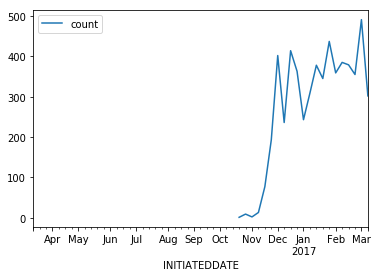

In [20]:
odwo['count'] = 1
odwo['INITIATEDDATE'] = pd.to_datetime(odwo['INITIATEDDATE'])
odwo[mask][['INITIATEDDATE','count']].resample('w', on='INITIATEDDATE').sum().plot()

In [21]:
wo.entereddate.min(), wo.entereddate.max()

(Timestamp('2005-06-17 00:00:00'), Timestamp('2016-11-28 09:31:58'))

In [22]:
mask4 = wo.resolveddatetime > '2016-01-01'

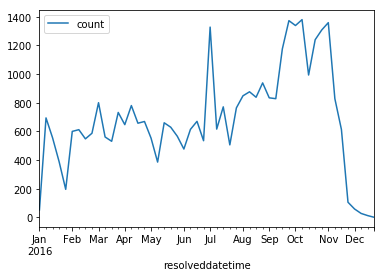

In [23]:
wo['count'] = 1
wo[mask3 & mask4][['resolveddatetime','count']].resample('w', on='resolveddatetime').sum().plot()

This looks good -- one data set picks up where the other leaves off.  Now let's combine them. 

# Combining the workorder data sets and the inventory data set. 

The two data sets have different variable names, so before we combine them let's standardize the names.
Arbitrarily, I'm going to add the open data portal data to the islims data rather then the other way around. 
Then I'll assign inventory details wherever they are available. 

In [24]:
wo.columns

Index(['woID', 'inventoryID', 'srchAssetID', 'gpscoordinateX',
       'gpscoordinateY', 'initialproblemID', 'resolveddatetime', 'entereddate',
       'finalresolutionID', 'count'],
      dtype='object')

In [25]:
odwo.columns

Index(['OBJECTID', 'WORKORDERID', 'PROJECTID', 'DESCRIPTION', 'STATUS',
       'INITIATEDDATE', 'WORKORDERCLOSEDDATE', 'ACTUALSTARTDATE',
       'ACTUALFINISHDATE', 'PROJECTNAME', 'PRIORITY', 'SOURCEWORKORDERID',
       'CYCLETYPE', 'SCHEDULEDATE', 'WORKORDERCATEGORY', 'UNATTACHED',
       'WORKORDERCOST', 'WORKORDERLABORCOST', 'WORKORDERMATERIALCOST',
       'WORKORDEREQUIPMENTCOST', 'SUBMITTEDTO', 'SUBMITTEDTODATE',
       'WORKCOMPLETEDBY', 'WORKORDERCLOSEDBY', 'ISCANCELED', 'CANCELEDBY',
       'CANCELEDDATE', 'ASSETGROUP', 'SUPERVISOR', 'REQUESTEDBY',
       'INITIATEDBY', 'ADDRESS', 'FISCALYEAR', 'WARD', 'QUADRANT', 'ZIPCODE',
       'ANC', 'SMD', 'NEIGHBORHOODCLUSTERS', 'NEIGHBORHOODNAMES', 'BID', 'AWI',
       'EDZ', 'NIF', 'HISTORICDISTRICT', 'ZONING', 'PUD', 'CFAR', 'PSA', 'PD',
       'DAYSTOCLOSE', 'UPDATEDATE', 'XCOORD', 'YCOORD', 'ONSEGX', 'ONSEGY',
       'LONGITUDE', 'LATITUDE', 'geometry', 'count'],
      dtype='object')

In [26]:
old_vars = ['WORKORDERID', '', '', 'XCOORD', 'YCOORD', 'ONSEGX', 'ONSEGY', 'LONGITUDE', 'LATITUDE' ]
new_vars = ['woID', 'inventoryID', 'srchAssetID', 'gpscoordinateX', 'gpscoordinateY', 'initialproblemID', 'resolveddatetime', 'entereddate', 'finalresolutionID']

In [27]:
wo.head()

,woID,inventoryID,srchAssetID,gpscoordinateX,gpscoordinateY,initialproblemID,resolveddatetime,entereddate,finalresolutionID,count
0,65209,4,-???-,NaN,NaN,55,2005-06-20,2005-06-17 00:00:00,55,1
1,66089,4,-???-,NaN,NaN,32,2005-08-22,2005-08-16 00:00:00,32,1
2,67632,4,-???-,NaN,NaN,55,2005-12-08,2005-12-07 00:00:00,55,1
3,68957,4,-???-,NaN,NaN,12,2006-03-22,2006-03-22 07:15:44,190,1
4,68958,4,-???-,NaN,NaN,12,2006-03-22,2006-03-22 07:40:33,190,1


In [28]:
odwo['ASSETGROUP'].head()

0    UFA
1    UFA
2    UFA
3    UFA
4    UFA
Name: ASSETGROUP, dtype: object

In [29]:
# stopping here for now ... but hopefully it's obvious what comes next